In [24]:
from transformers import (
    TrainingArguments,
    HfArgumentParser,
    LayoutLMv3ForTokenClassification,
    set_seed,
)


In [25]:
from obc_dataset_seq import ObcReadingOrderDataset, DataLoader
from seq_split_model import SeqProcessMlModel
from transformers import BertTokenizer
import json
import os
import glob
import torch.nn as nn
import torch
import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.nn.functional as F
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score
from collections import Counter
import numpy as np

In [26]:


def evaluate_clustering(true_labels, pred_labels):
    def cluster_purity(y_true, y_pred):
        cluster_labels = set(y_pred)
        total_correct = 0
        for cluster in cluster_labels:
            indices = np.where(y_pred == cluster)[0]
            true_labels_in_cluster = y_true[indices]
            if len(true_labels_in_cluster) == 0:
                continue
            most_common = Counter(true_labels_in_cluster).most_common(1)[0][1]
            total_correct += most_common
        return total_correct / len(y_true)

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    return {
        "AMI": adjusted_mutual_info_score(true_labels, pred_labels),
        "NMI": normalized_mutual_info_score(true_labels, pred_labels),
        "ARI": adjusted_rand_score(true_labels, pred_labels),
        "Purity": cluster_purity(true_labels, pred_labels)
    }


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
bert_tokenizer = BertTokenizer.from_pretrained("oracle_bert_sub")
dataset = ObcReadingOrderDataset(
        tokenizer=bert_tokenizer,
        data_dir="datasets_sub/test_dataset.json",
        enhance_random_char_p=0.0
    )

In [29]:
model = SeqProcessMlModel("oracle_bert_sub", 4, 100, dataset.seq_max_length + 1).to(device)

In [30]:
checkpoint_dir = f"checkpoints_exp_sub/{dataset.__class__.__name__}"

state_dict = torch.load(f"{checkpoint_dir}/last.pt")
load_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        load_state_dict[k[len("module."):]] = v
model.load_state_dict(load_state_dict)
model.eval()
print("load checkpoint done")

load checkpoint done


In [31]:
from sklearn.cluster import DBSCAN, KMeans
from collections import defaultdict
import tqdm

In [32]:
import networkx as nx
import community  # python-louvain
import numpy as np

def louvain_clustering(adjacency_matrix: np.ndarray, edge_confidence=0.8):
    G = nx.Graph()
    M = len(adjacency_matrix)

    # 构建图
    for i in range(M):
        for j in range(i + 1, M):
            if adjacency_matrix[i][j]:
                G.add_edge(i, j, weight=edge_confidence)

    # Louvain 聚类
    partition = community.best_partition(G, weight='weight')

    # 将聚类编号转换为列表形式，索引表示节点编号，值为聚类编号
    labels = [partition.get(i, -1) for i in range(M)]

    # 为了输出美观、聚类编号从0开始、连续，进行编号映射
    unique_ids = sorted(set(labels))
    id_map = {old: new for new, old in enumerate(unique_ids)}
    remapped_labels = [id_map[label] for label in labels]

    return remapped_labels




In [34]:
obc_train_loader = DataLoader(
        dataset,
        batch_size = 1,
        shuffle=True,
        collate_fn=dataset.collate_fn
    )

k_preds = []
k_gts =  []

evals_total = defaultdict(lambda: [])
for batch_input in tqdm.tqdm(obc_train_loader):
    batch_input = {k: v.to(device) for k, v in batch_input.items() if isinstance(v, torch.Tensor)}
    inputs = {
        "input_ids": batch_input['input_ids'],
        "attention_mask": batch_input['attention_mask'],
        "position_ids": batch_input['positions'],
    }

    k_gt = batch_input['K']
    order_ids = batch_input['order_ids']
    sentence_ids = batch_input['sentence_ids']
    
    seq_logic, sort_logic, k_pred = model(inputs, sentence_ids)
    
    k_pred = k_pred.max(-1)[-1].item()
    k_real = k_gt.item()
    
    
    
    tensor = F.normalize(seq_logic, 2, -1)[0].detach().cpu().numpy()
    tensor=tensor[1:]
    cluster_k = k_pred if k_pred <= tensor.shape[0] else tensor.shape[0]
    if cluster_k == 0:
        continue
    # kmeans = KMeans(n_clusters=cluster_k, 
    #                 init='k-means++', random_state=42, tol=5, max_iter=1000)
    # labels = kmeans.fit_predict(tensor)
    
    # dist = torch.cdist(torch.from_numpy(tensor), torch.from_numpy(tensor)) < 0.2
    # labels = louvain_clustering(dist.numpy(), 0.2)
    
    dbscan = DBSCAN(eps=0.15, min_samples=2)  # eps 和 min_samples 需根据数据调优
    labels = dbscan.fit_predict(tensor)
    
    eval_result = evaluate_clustering(sentence_ids[0][1:].detach().cpu().numpy(), labels)
    
    for name, score in eval_result.items():
        evals_total[name].append(score)

    
    len(set(labels))
    # k_preds.append(k_pred)  
    k_preds.append(len(set(labels)))  
    k_gts.append(k_real)

for key, scores in evals_total.items():
    print(key, np.mean(scores))


100%|██████████| 1008/1008 [00:40<00:00, 24.64it/s]

AMI 0.5135802816812648
NMI 0.5327891380609244
ARI 0.5024158805242709
Purity 0.7994156400052178


In [38]:
k_preds_t = torch.tensor(k_preds)
k_gts_t = torch.tensor(k_gts)
print(f"K-pred Acc: {(k_preds_t == k_gts_t).sum() / len(k_preds)}")


err_mask = ~(k_preds_t == k_gts_t)
acc = (k_gts_t[err_mask] - k_preds_t[err_mask]).abs().sum() / len(k_preds_t[err_mask])
print(f"K-offest: {acc}")

K-pred Acc: 0.5625
K-offest: 1.6507936716079712


In [39]:
obc_train_loader = DataLoader(
        dataset,
        batch_size = 1,
        shuffle=True,
        collate_fn=dataset.collate_fn)

In [40]:
data = iter(obc_train_loader)

In [41]:
item_data = data._next_data()
item_data

{'input_ids': tensor([[1733,  209,  234,  852,  977, 1488, 1730, 1730,  659,  882,   86,  596,
          1412, 1730]]),
 'attention_mask': tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True],
          [ True,  True, False, False, False,  True,  True,  True, False, False,
           False,  True, False,  True],
          [ True,  True,  True, False, False, False, False,  True, False,  True,
           False,  True, False, False],
          [ True,  True, False,  True, False, False,  True, False,  True,  True,
           False, False, False, False],
          [ True, False,  True, False,  True, False, False, False, False,  True,
            True,  True,  True,  True],
          [ True,  True,  True, False,  True,  True, False,  True, False, False,
           False, False, False, False],
          [ True,  True,  True,  True, False, False,  True, False, False, False,
           False,  True, False, False],
          [ Tru

In [42]:
batch_input = {k: v.to(device) for k, v in item_data.items() if isinstance(v, torch.Tensor)}
            
inputs = {
    "input_ids": batch_input['input_ids'],
    "attention_mask": batch_input['attention_mask'],
    "position_ids": batch_input['positions'],
}

k_gt = batch_input['K']
order_ids = batch_input['order_ids']
sentence_ids = batch_input['sentence_ids']

In [43]:
seq_logic, sort_logic, k_pred = model(inputs, sentence_ids)

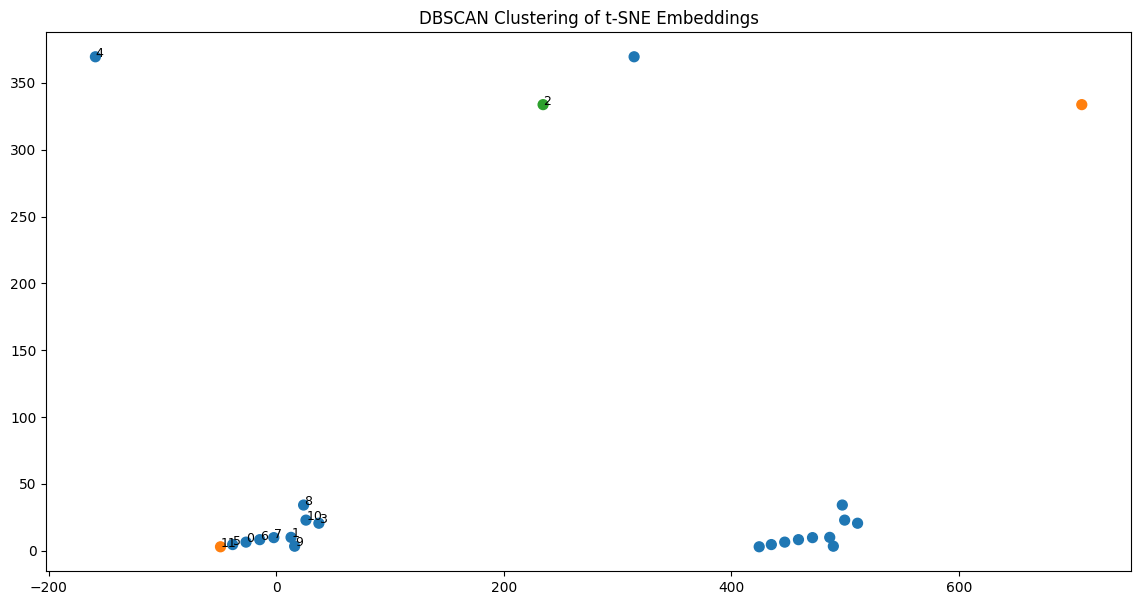

{'AMI': 0.6178607306769147,
 'NMI': 0.6725962668139219,
 'ARI': 0.6,
 'Purity': 0.9166666666666666}

In [44]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import torch.nn.functional as F

tensor = F.normalize(seq_logic, 2, -1)[0].detach().cpu().numpy()
tensor=tensor[1:]

# 使用 DBSCAN 聚类
dbscan = DBSCAN(eps=0.15, min_samples=1)  # eps 和 min_samples 需根据数据调优
labels = dbscan.fit_predict(tensor)

# kmeans = KMeans(n_clusters=k_pred.max(-1)[-1].item(), init='k-means++', random_state=42, tol=1, max_iter=300)
# labels = kmeans.fit_predict(tensor)


# dist = torch.cdist(torch.from_numpy(tensor), torch.from_numpy(tensor)) < 0.1
# labels = louvain_clustering(dist.numpy(), 0.7)
# labels = np.array(labels)
# t-SNE 降维

tsne = TSNE(n_components=2, perplexity=1, random_state=0)
tensor_2d = tsne.fit_transform(tensor)

# 可视化聚类结果
plt.figure(figsize=(14, 7))
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# print(f"自动检测的聚类数量: {num_clusters}", "预测的聚类数量: ", k_pred.max(-1)[-1].item())

# 颜色映射：-1 是噪声点
colors = [plt.cm.tab10(label % 10) if label != -1 else 'k' for label in item_data["sentence_ids"][0][1:].tolist()]
plt.scatter(tensor_2d[:, 0], tensor_2d[:, 1], c=colors, s=50)
colors = [plt.cm.tab10(label % 10) if label != -1 else 'k' for label in labels]
plt.scatter(tensor_2d[:, 0] + (tensor_2d[:, 0].max() - tensor_2d[:, 0].min()) + 80, tensor_2d[:, 1], c=colors, s=50)

# 添加点标签
for i, (x, y) in enumerate(tensor_2d):
    plt.text(x + 0.3, y, str(i), fontsize=9)

plt.title("DBSCAN Clustering of t-SNE Embeddings")
plt.show()

evaluate_clustering(item_data["sentence_ids"][0][1:].numpy(), labels)

In [45]:
item_data["sentence_ids"][0][1:].numpy()

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1])